# Verification for Cutoffs
In this notebook we examine the historgram of # of contours extracted as a function of cutoff size. We also plot a few example simulation images with keypoints overlayed to illustrate the difference.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numba import prange
from skimage import feature as skif
from skimage.feature import blob_log
from sklearn.model_selection import ParameterGrid, KFold
from sklearn.tree import DecisionTreeRegressor
from IPython.display import clear_output
from itertools import product
%matplotlib inline

In [17]:
# Precharattana Model constants
CELL_H   = 0
CELL_A2  = 1
CELL_A0  = 2
CELL_A1  = 4
CELL_D   = 8

mycmap = {
    CELL_H: [255, 255, 255],
    CELL_A2: [0, 255, 0],
    CELL_A0: [128, 128, 0],
    CELL_A1: [0, 128, 0],
    CELL_D: [0, 0, 0], 
}

names = {
    CELL_H: 'Healthy',
    CELL_A2: 'Stage 1 Infected',
    CELL_A0: 'Latent Infected',
    CELL_A1: 'Stage 2 Infected', 
    CELL_D: 'Dead', 
}

## Loading Data

In [18]:
from numba import types
from numba import njit
from numba.typed import Dict
int_array = types.int64[:]

In [19]:
@njit(parallel=True)
def proc(picture):
    healthy, dead, infected_A1, infected_A2 = 0, 0, 0, 0
    mycmap = Dict.empty(
        key_type=types.float64,
        value_type=int_array
    )
    data = np.zeros((600, 600, 3), dtype=np.uint8)
    mycmap[CELL_H] = np.array((255, 255, 255))
    mycmap[CELL_A2] = np.array((0, 255, 0))
    mycmap[CELL_A0] = np.array((128, 128, 0))
    mycmap[CELL_A1] = np.array((0, 128, 0))
    mycmap[CELL_D] = np.array((0, 0, 0))
    for row in range(0, len(data)):
        for col in range(0, len(data)):
            if picture[row][col] == 0:
                healthy += 1
            elif picture[row][col] == 1:
                infected_A2 += 1
            elif picture[row][col] == 2:
                infected_A1 += 1
            else:
                dead += 1
            data[row][col] = mycmap[picture[row][col]]
    return healthy, infected_A1, infected_A2, dead, data

In [20]:
healthyArr = []
deadArr = []
infected_A1Arr = []
infected_A2Arr = []
data_extract = []

for i in range(0,601,40):
    picture = np.load(str(i)+'.npz')['arr_0']
    healthy, dead, infected_A1, infected_A2, data = proc(picture)
    
    healthyArr.append(healthy)
    deadArr.append(dead)
    infected_A1Arr.append(infected_A1)
    infected_A2Arr.append(infected_A2)
    
    data_extract.append(data)

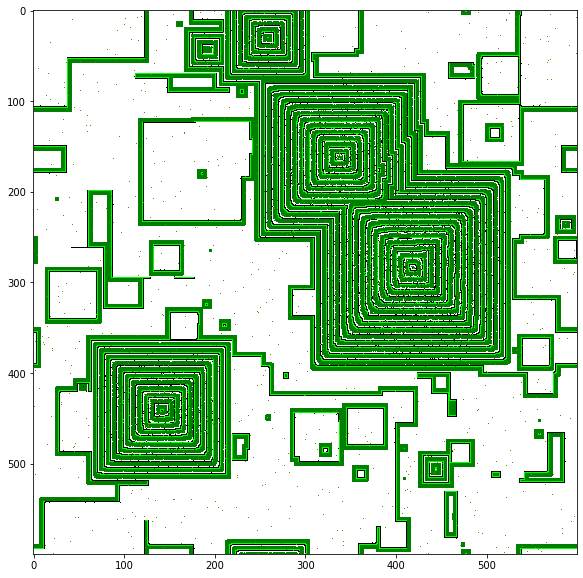

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
im = plt.imshow(data_extract[5])

## Plotting Histograms
We use the optimized feature extraction functions in Milestone 2 to plot such histograms. We don't need to extract all the features, just the counts of "hits" to justify why our choice of cutoffs.

### Feature Extraction Functions
Listed below are the functions necessary for feature extraction.

In [22]:
import numpy as np
import cv2
from numba import jit, prange
from skimage import feature as skif
from skimage.feature import blob_log

In [23]:
# Numerically encoded cell states, after being processed by
# the master script.
CELL_N = 0  # Non activated
CELL_H = 1  # Healthy
CELL_A1 = 2  # Acute Infected
CELL_A2 = 3  # Latent Infected
CELL_D = 4  # Dead

# Dictionary to convert Precharattana model to uniform states. 0:1(healthy),
# 4:2(acute infected), 1:2(acute infected), 2:3(latent infected), 8:4(dead)
precharattana_dict = {0: 1, 4: 2, 1: 2, 2: 3, 8: 4}

# Dictionary to convert the Rana model to uniform states. 0:1(healthy),
# 2:1(healthy), 8:1(healthy), 10:1(healthy), 4:2(acute infected),
# 1:3(latent infected), 16:4(dead)
rana_dict = {0: 1, 2: 1, 8: 1, 10: 1, 4: 2, 1: 3, 16: 4}

# Self-defined color map. Used for openCV feature-extraction functions.
mycmap = {
    CELL_N: [127, 127, 127],
    CELL_H: [0, 255, 0],
    CELL_A1: [255, 0, 0],
    CELL_A2: [0, 0, 255],
    CELL_D: [0, 0, 0],
}

In [24]:
# Function that converts grids with raw values into a uniform set of values
# for all models.
@jit(nopython=True)
def im_convert(im, model):
    im_new = np.zeros((len(im), len(im[0])), dtype=np.uint8)
    if model == 'dossantos':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 8:
                    im_new[row][col] = 4
    elif model == 'moonchai':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 0
                elif value == 4:
                    im_new[row][col] = 1
                elif value == 2:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 8:
                    im_new[row][col] = 4
    elif model == 'precharattana':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 2
                elif value == 2:
                    im_new[row][col] = 3
                elif value == 8:
                    im_new[row][col] = 4
    elif model == 'rana':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 2:
                    im_new[row][col] = 1
                elif value == 8:
                    im_new[row][col] = 1
                elif value == 10:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 16:
                    im_new[row][col] = 4
    elif model == 'gonzalez':
        for row in prange(0, len(im)):
            for col in prange(0, len(im[0])):
                value = im[row][col]
                if value == 0:
                    im_new[row][col] = 1
                elif value == 2:
                    im_new[row][col] = 1
                elif value == 8:
                    im_new[row][col] = 1
                elif value == 10:
                    im_new[row][col] = 1
                elif value == 4:
                    im_new[row][col] = 2
                elif value == 1:
                    im_new[row][col] = 3
                elif value == 16:
                    im_new[row][col] = 4
    return im_new

In [25]:
# Helper function that takes a grid and returns an image operable by openCV.
@jit(nopython=True)
def gridToOpenCVImage(grid):
    # Create a L by L by 3 np array
    shape = grid.shape
    res = np.zeros((shape[0], shape[1], 3), dtype=np.uint8)

    CELL_N_ARR = np.array([127, 127, 127], dtype=np.uint8)
    CELL_H_ARR = np.array([0, 255, 0], dtype=np.uint8)
    CELL_A1_ARR = np.array([255, 0, 0], dtype=np.uint8)
    CELL_A2_ARR = np.array([0, 0, 255], dtype=np.uint8)
    CELL_D_ARR = np.array([0, 0, 0], dtype=np.uint8)

    # Note that openCV stores image in BGR format. The colors
    # in mycmap are given in RGB.
    for row in prange(len(grid)):
        for col in prange(len(grid[0])):
            # Gets the color in mycmap and reverse it to BGR
            value = grid[row][col]

            if value == CELL_N:
                res[row][col] = CELL_N_ARR[::-1]
            elif value == CELL_H:
                res[row][col] = CELL_H_ARR[::-1]
            elif value == CELL_A1:
                res[row][col] = CELL_A1_ARR[::-1]
            elif value == CELL_A2:
                res[row][col] = CELL_A2_ARR[::-1]
            else:
                res[row][col] = CELL_D_ARR[::-1]
    return res

In [31]:
# def getContourFeatures(grid):

# Grabs all contour edges from an image and calculates the perimeter of the contours
def contour_perim(im, min_perim):
    imOrig = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY);
    ret, thresh = cv2.threshold(imOrig, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1:]  # First contour is the whole image, so it is removed

    cnt_perim = np.array(list(map(lambda x: cv2.arcLength(x, True), contours)))
    cnt_perim_filtered = cnt_perim[cnt_perim > min_perim]
    return cnt_perim_filtered if cnt_perim_filtered.size > 0 else [0]

# Grabs all contour edges from an image and calculates the area of the contours
def contour_area(im, min_area):
    imOrig = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY);
    ret, thresh = cv2.threshold(imOrig, 127, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1:]  # First contour is the whole image, so it is removed

    cnt_area = np.array(list(map(lambda x: cv2.contourArea(x), contours)))
    cnt_area_filtered = cnt_area[cnt_area > min_area]
    return cnt_area_filtered if cnt_area_filtered.size > 0 else [0]
    
# This function takes a grid as input and finds the number of blobs at various cutoffs
# @njit(parallel=True)
def getContourParameterFeatures(grid):
    counts = [None] * 100
    for cutoff in range(100):
        counts[cutoff] = contour_perim(gridToOpenCVImage(grid), cutoff)
    return counts

def getContourAreaFeatures(grid):
    counts = [None] * 100
    for cutoff in range(100):
        counts[cutoff] = contour_area(gridToOpenCVImage(grid), cutoff)
    return counts

### Feature Extraction
We select a few frames and plot the histogram for them.

In [27]:
# These things are used the legends
import matplotlib.patches as mpatches
colors = {
    'CELL_H': [0, 255, 0],
    'CELL_A1': [255, 0, 0],
    'CELL_A2': [0, 0, 255],
    'CELL_D': [0, 0, 0],
}

names = {
    'CELL_H': 'Healthy',
    'CELL_A1': 'Acute Infected',
    'CELL_A2': 'Latent Infected',
    'CELL_D': 'Dead'
}

In [28]:
features_dict = {}

1) Grab some data to run the model below

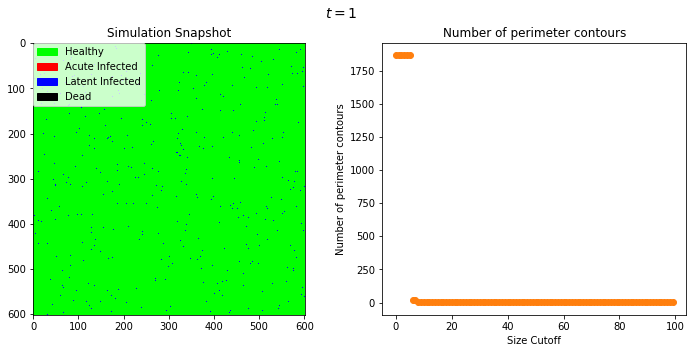

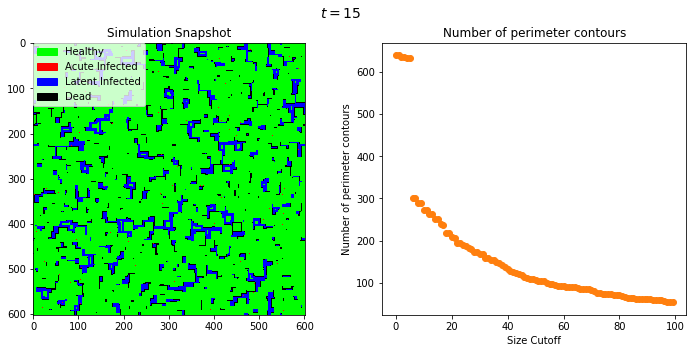

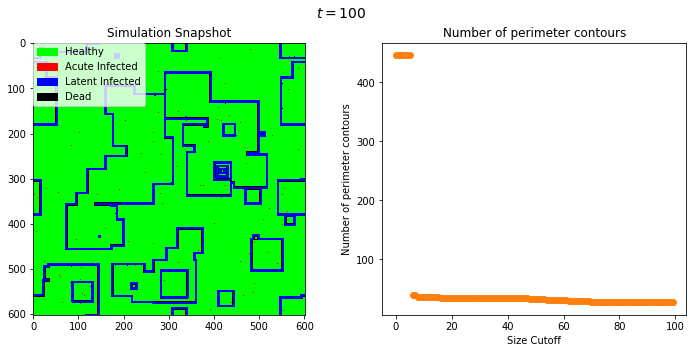

In [41]:
# justification for contour perimeter cutoffs
timesteps = [0, 15, 100]
timesteps_display = [1, 15, 100]
for time, disp_time in zip(timesteps, timesteps_display):
    data = im_convert(np.load(f'{time}.npz')['arr_0'], 'precharattana')
    img = gridToOpenCVImage(data)
    features_dict[time] = getContourParameterFeatures(data)
    
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(range(100), list(map(lambda l : len(l), features_dict[time])), color='#ff7f0e')
    ax2.imshow(img)
    ax1.set_title('Number of perimeter contours')
    ax1.set_xlabel('Size Cutoff')
    ax1.set_ylabel('Number of perimeter contours')
    ax2.set_title('Simulation Snapshot')
    patches = [mpatches.Patch(color=np.array(colors[k]) / 255, label=names[k]) for k in colors]
    ax2.legend(handles=patches, bbox_to_anchor=(0, 1), loc=2, borderaxespad=0. )
    fig.suptitle(f'$t={disp_time}$', fontsize=14)
    plt.savefig(f'{time}_perim.pdf')
    plt.show()

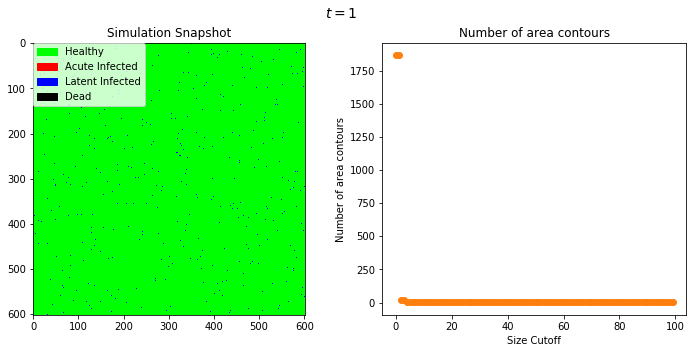

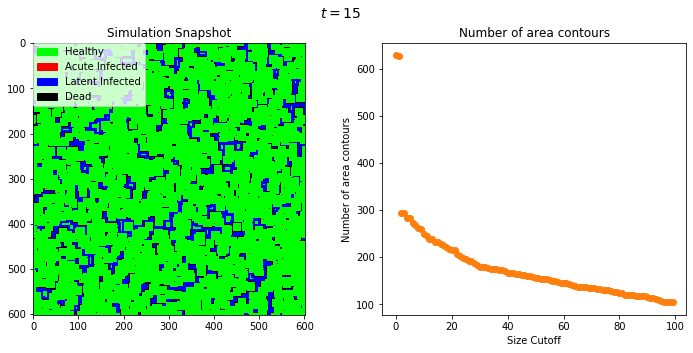

In [43]:
# justification for contour area cutoffs
timesteps = [0, 15, 100]
timesteps_display = [1, 15, 100]
for time, disp_time in zip(timesteps, timesteps_display):
    data = im_convert(np.load(f'{time}.npz')['arr_0'], 'precharattana')
    img = gridToOpenCVImage(data)
    features_dict[time] = getContourAreaFeatures(data)
    
    fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.scatter(range(100), list(map(lambda l : len(l), features_dict[time])), color='#ff7f0e')
    ax2.imshow(img)
    ax1.set_title('Number of area contours')
    ax1.set_xlabel('Size Cutoff')
    ax1.set_ylabel('Number of area contours')
    ax2.set_title('Simulation Snapshot')
    patches = [mpatches.Patch(color=np.array(colors[k]) / 255, label=names[k]) for k in colors]
    ax2.legend(handles=patches, bbox_to_anchor=(0, 1), loc=2, borderaxespad=0. )
    fig.suptitle(f'$t={disp_time}$', fontsize=14)
    plt.savefig(f'{time}_area.pdf')
    plt.show()